# DNA RL: Crossover based optimization algorithm

Importing Libraries

In [1]:
import dna_env
import a2c
import torch
import variable as v
from tqdm import tqdm
from train_session import TrainSession
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

Initializing Environment

In [2]:
sequence_length = 36
render = True
state_representation = 'latent'
use_test_set = True
action_constraints = {'co_length': (-1, 36), 
                      'opt_start_point': (-1, 36),
                      'co_start_point': (-1, 36)}
early_stop_reward = {'reward_low_threshold': -1,
                     'reward_high_threshold': .9, 
                     'patience': 200}
env = dna_env.DnaRLEnv(action_constraints=action_constraints, 
                       early_stop_reward=early_stop_reward, 
                       use_test_set=use_test_set,
                       sequence_length=sequence_length, 
                       state_representation=state_representation)
env.reset()
train_session = None

In [3]:
seed = 29
state_dim = env.get_state_dim()
action_dim = env.get_action_dim()
print(f"state dim: {state_dim}")
print(f"action dim: {action_dim}")

state dim: (400,)
action dim: (3, 36)


Creating our agent

In [4]:
critic_init = {
    'seed': seed,
    'action_dim': action_dim[0],
    'state_representation': state_representation,
    'network': {
        'i_size': state_dim[0],
        'l1_size': 100,
        'l2_size': 20,
               },
    'optimizer': {
        'lr': 1e-3
    }
}
actor_init = {
    'entropy_learning_rate': .3,
    'seed': seed,
    'action_dim': action_dim[0],
    'state_representation': state_representation,
    'network': {
        'i_size': state_dim[0], 
        'l1_size': 200,
        'hidden_size': 75,
        'o_size': sequence_length
               },
    'optimizer': {
        'lr': 1e-3
    }
}
a2c_init = {
    'actor_type': 'actor_rnn',
    'seed': seed,
    'discount_factor': 1.0, 
    'state_dim': state_dim, 
    'action_space': 3, 
    'actor': actor_init, 
    'critic': critic_init
}

In [5]:
if not train_session:
    print('Train Session reset')
    train_session = TrainSession({}, env, seed)

Train Session reset


In [6]:
agents_created = {
    'a2c_agent': a2c.A2C(a2c_init)
}
manual_agent_names = train_session.append_agents(agents_created)

In [7]:
all_agent_names = train_session.agents.keys()
s = '\n- '.join(all_agent_names)
print(f"All Agents: \n- {s}")

All Agents: 
- a2c_agent


In [8]:
# train_session.load_model('a2c_agent', suffix='0710-raw')

In [9]:
n_episode = 25
t_max_per_episode = 100
graphical = False

In [10]:
train_session.train(n_episode=n_episode, t_max_per_episode=t_max_per_episode,
                    graphical=graphical, agent_subset=manual_agent_names)

100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


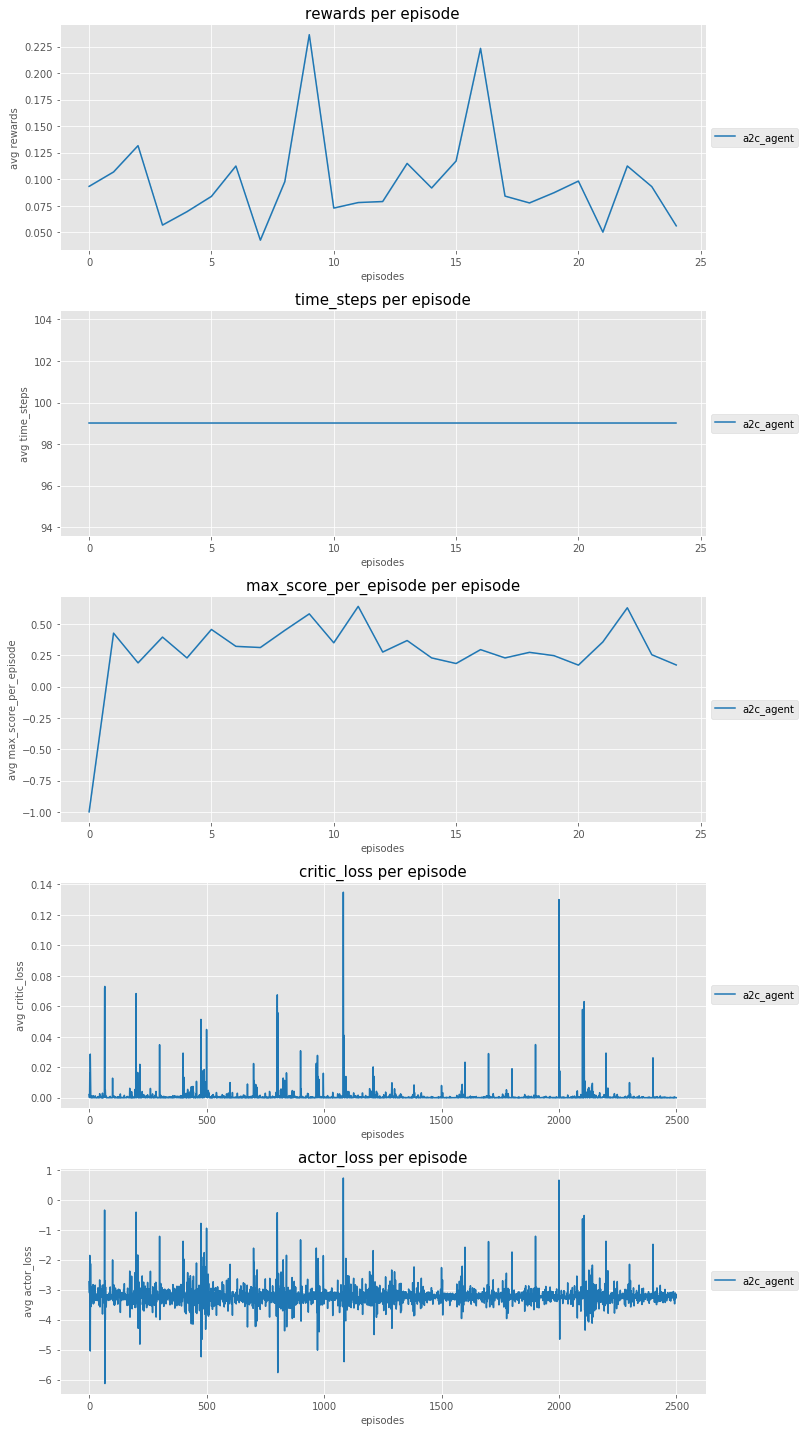

In [11]:
train_session.plot_results(window=1, agent_subset=manual_agent_names)

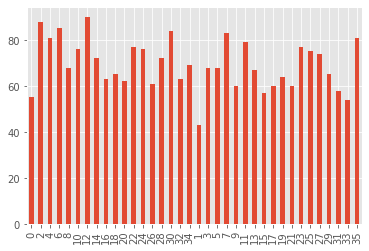

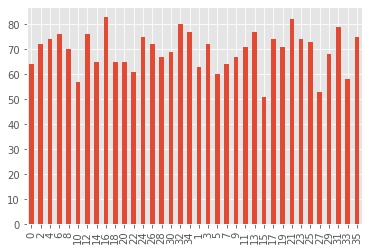

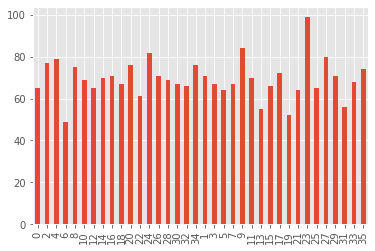

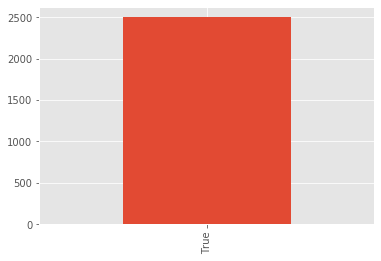

<Figure size 432x288 with 0 Axes>

In [12]:
train_session.env.actions_analysis()

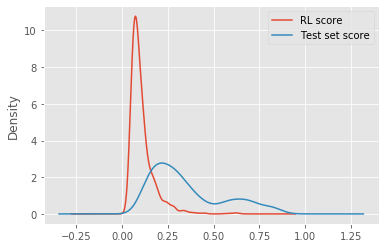

In [13]:
train_session.plot_density()

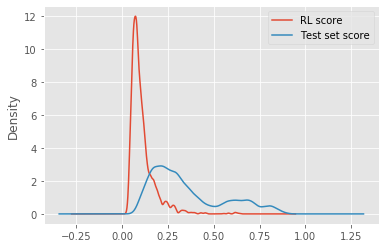

In [31]:
import pandas as pd
scores = pd.Series(train_session.env.oracle_scores, name='RL score')
test_set = pd.read_csv("test_set.csv", index_col=0)
test_set_scores = test_set.loc[:, train_session.env.reward_func_goal].rename('Test set score')
pd.concat([scores, test_set_scores], axis=1).plot.kde(bw_method=.1)

In [15]:
test_set.shape

(2265, 2)

In [11]:
train_session.save_model(suffix='0710-raw')

In [13]:
a = np.array(train_session.rewards_per_episode["a2c_agent"])[1:]

In [14]:
a[a <= 0]

array([-169.85291323,  -29.93677123,   -9.94647928,  -29.95776756,
         -9.89340588,   -9.87795719,   -9.94244637,  -19.88838159,
         -9.78376144,   -9.94982777,  -69.93105348,   -9.92366278,
         -9.95317671,   -9.88481782,   -9.78837796,   -9.93631242,
         -9.97285929,   -9.89520814,   -9.84451327,   -9.93995072,
        -19.92200837,   -9.77168891,   -9.86824988,   -9.79042137,
         -9.7880377 ,  -19.92578671,  -19.89814471,   -9.94313581,
         -9.86924613,   -9.94185011,   -9.77627863,  -19.81795828,
        -19.96410682,   -9.93081892,   -9.89157464,   -9.85105807,
         -9.8956165 ,   -9.89934511,  -19.92032801,   -9.91549184,
        -19.908712  ,  -29.94066104,  -19.89826294,   -9.9509282 ,
        -79.9282086 ,  -29.93356854,   -9.92194422,   -9.82230216,
         -9.85910945,  -29.93324846,   -9.87466204,   -9.92347696,
         -9.88264262,  -19.89463998,   -9.94023002,   -9.97023582,
         -9.94733138,   -9.92451993,   -9.92266302, -159.90508

In [27]:
b = np.array(train_session.reward_per_time_step["a2c_agent"])[1:]

In [28]:
b[b >= 0].shape[0] - b[b <= 0].shape[0]

886

In [21]:
train_session.reward_per_time_step["a2c_agent"][train_session.reward_per_time_step["a2c_agent"] > .60]

array([0.6667548 , 0.60170127, 0.65782997, 0.63893074, 0.66179251,
       0.64561439, 0.70317611, 0.71903552, 0.68008956, 0.60722298,
       0.6909626 , 0.75096821, 0.62512117, 0.72650619, 0.606064  ,
       0.63476332, 0.77182073, 0.63462014, 0.6488169 , 0.61257225,
       0.6657833 , 0.62061772, 0.60348487, 0.64077849, 0.68226678,
       0.70294759, 0.64984097, 0.7633385 , 0.64267869, 0.6790415 ,
       0.60613658, 0.66673484, 0.65242333, 0.85447252, 0.69232798,
       0.67011794, 0.64340799, 0.67846479, 0.73180237, 0.61950533,
       0.68784258, 0.68916307, 0.68294038, 0.62396943, 0.73442558,
       0.71184662, 0.75954778, 0.67736588, 0.6027206 , 0.77295759,
       0.75905788, 0.78492733, 0.76038253, 0.67871556, 0.62265427,
       0.64268848, 0.75894994, 0.61272737, 0.78926467, 0.64902449,
       0.682592  , 0.75606137, 0.63285924, 0.60175642, 0.67535348,
       0.64948897, 0.61287603, 0.661961  , 0.68116212, 0.63662113,
       0.62037278, 0.68894646, 0.64492404, 0.60454041, 0.64057

In [27]:
np.ma.apply_along_axis(np.ma.masked_not_equal(train_session.reward_per_time_step["a2c_agent"], -1.0))

TypeError: apply_along_axis() missing 2 required positional arguments: 'axis' and 'arr'

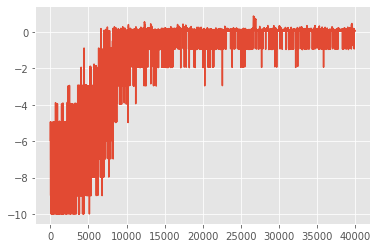

In [10]:
import numpy as np
train_session.reward_per_time_step["a2c_agent"] = np.ma.masked_not_equal(train_session.reward_per_time_step["a2c_agent"], -1.0)
series_mvg = utils.rolling_window(train_session.reward_per_time_step["a2c_agent"], window=10)
series_mvg_avg = np.mean(series_mvg, axis=1)
plt.plot(range(len(series_mvg_avg)), series_mvg_avg)

In [37]:
train_session.agents["a2c_agent"].critic(torch.rand(1, 400).cuda())

tensor([[-0.0450]], device='cuda:0', grad_fn=<AddmmBackward>)

In [25]:
state = env.reset()

In [13]:
(1, ) + state.shape

(1, 400)

In [10]:
a = torch.tensor([11, 23,  3], device=v.device)

In [13]:
a.cpu().numpy()

array([11, 23,  3])

In [17]:
a.prod()

tensor(759, device='cuda:0')

In [10]:
import utils

In [16]:
utils.to_tensor([[float(3)]])


tensor([[3.]], device='cuda:0')

In [61]:
torch.save(train_session.agents["a2c_agent"].critic.state_dict(), "/home/benoit/Documents/work/RL_DNA/saved_model/a2c_agent_critic_1.pth")

In [62]:
torch.save(train_session.agents["a2c_agent"].actor.state_dict(), "/home/benoit/Documents/work/RL_DNA/saved_model/a2c_agent_actor_1.pth")

In [36]:
max([.9, .8])

0.9